In [1]:
import numpy as np
import json
import pprint
from matplotlib import pyplot as plt
from collections import Counter
from fileoperations.fileoperations import get_filenames_in_dir
from morty.pitchdistribution import PitchDistribution
from morty.converter import Converter
from ahenkidentifier.ahenkidentifier import AhenkIdentifier
from copy import deepcopy
default_figsize = plt.rcParams['figure.figsize']


First the basic statistics: what is the distribution of makams and voicing/instrumentation in the dataset?

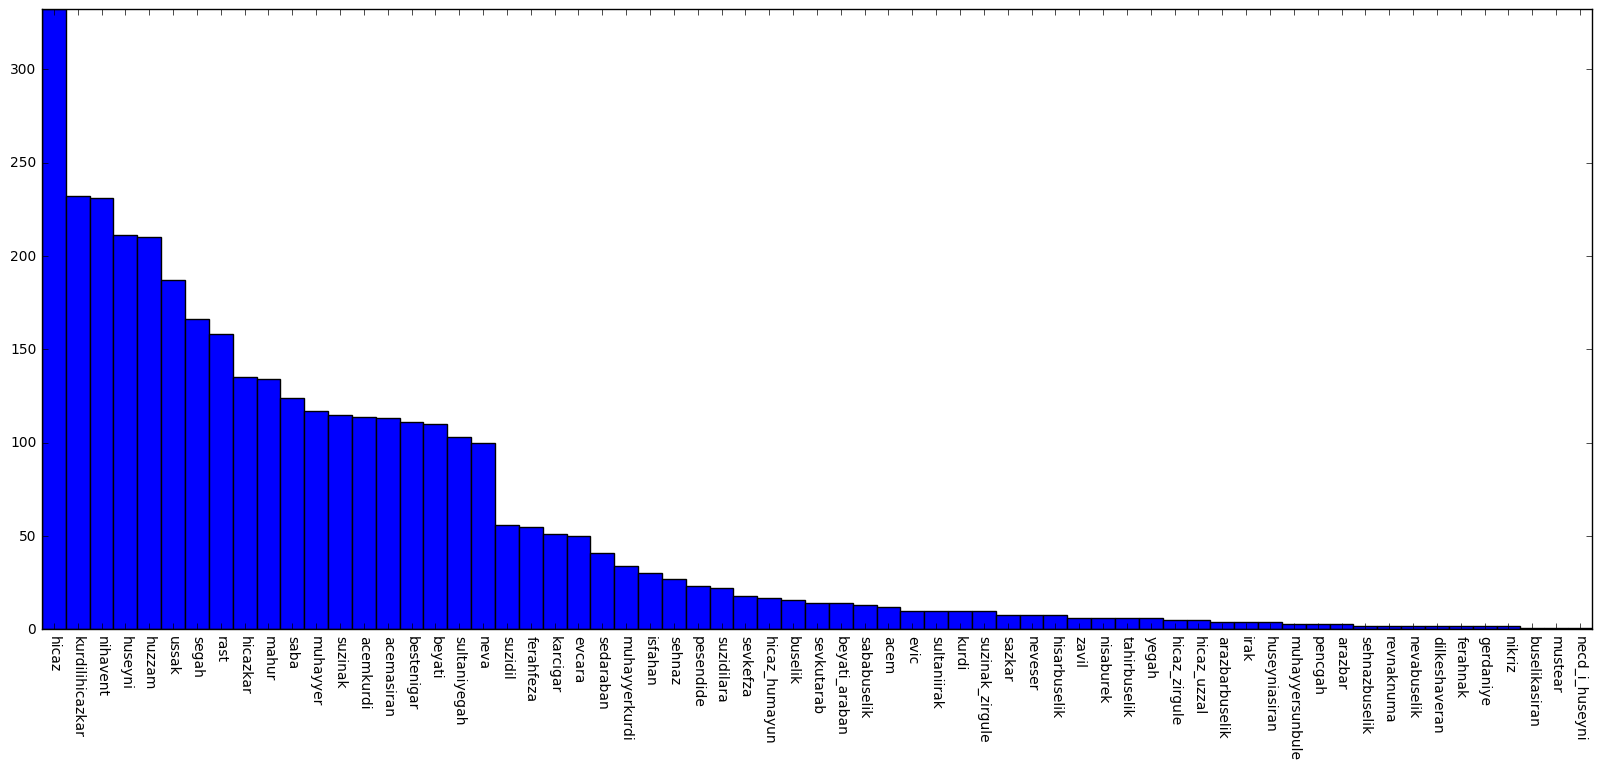

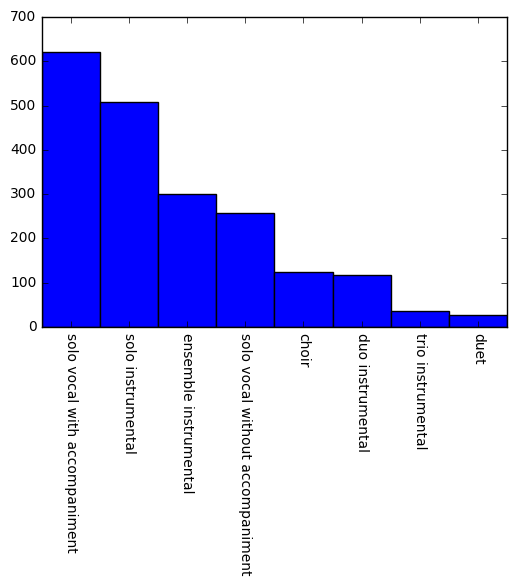

In [2]:
meta_files = get_filenames_in_dir('../metadata/', keyword='*.json')[0]
makams = []
instrumentation_voicing = []
for mf in meta_files:
    meta = json.load(open(mf))
    try:
        makams += [mm['attribute_key'] for mm in meta['makam']]
    except KeyError:  # no makam info
        pass
    instrumentation_voicing.append(meta['instrumentation_voicing'])
    # if meta['instrumentation_voicing'] == 'solo vocal without accompaniment':
    #    print meta['url']

# define bar_Chart method for convenience
def bar_chart(bar_list):
    cnt = Counter(bar_list)
    labels, values = zip(*cnt.most_common())

    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation='-90')

plt.rcParams['figure.figsize'] = (20, 8)  # make the figure wider
bar_chart(makams)
plt.axis('tight')
plt.show()
plt.rcParams['figure.figsize'] = default_figsize  # return to the default size
bar_chart(instrumentation_voicing)
plt.show()

__Warning:__ The recordings labeled as "solo vocal without accompaniment are mostly wrong. They typically have accompaniment, which was not labeled in MusicBrainz. This will be fixed in the future. See issue [#11](https://github.com/MTG/otmm_tonic_dataset/issues/11) for more details.

Below we are aggregating the tonic frequencies and their transpositions. For recordings, which have more than one annotation, we average the annotations. 

Due to possible differences in annotation octave, directly taking the mean of frequencies would be erroneous. In addition, the octave information is ill-defined for recordings in which each instrument play the same melody in their own register. For these reasons, initially wrapped the annotation into a single octave (centered around the frequency of the first annotation as a dummy reference) and then take the mean. 

Similarly, the [ahenkidentifier package](https://github.com/sertansenturk/ahenkidentifier) cannot distinguish "Bolahenk Nısfiye" from "Bolahenk" (see [this issue](https://github.com/sertansenturk/ahenkidentifier#issues)). It is OK, since we are reporting tonic pitch classes. 

If there is a change in tonic frequency over time in an audio recording, the time intervals are specified. This field if left empty, otherwise. We are ignoring recordings with variable tonic (there are very few cases).

We also note the total number of annotation and the absolute deviation (in cents) from the octave-wrapped average for recordings with more than one annotations.

In [3]:
tonic_json = json.load(open('../annotations.json'))
ahenk_identifier = AhenkIdentifier()

tonic_array = []
transposition_array = []
tonic_dev = []
nums_anno = []
num_auto_anno = 0
for value in tonic_json.values():
    temp_time = [annot['time_interval'] for annot in value['annotations']]
    temp_sym = set(annot['tonic_symbol'] for annot in value['annotations'])
    nums_anno.append(len(temp_time))
    
    # Skip if there is an annotated time interval
    if not any(tt for tt in temp_time):
        temp_tonic = np.array([annot['value'] for annot in value['annotations']])
        
        # wrap the frequencies around the first annotation
        dummy_tonic = temp_tonic[0] # the first annotation
        temp_tonic = np.array([Converter.hz_to_cent(tt, dummy_tonic) 
                               for tt in temp_tonic])
        temp_tonic = np.mod(temp_tonic, 1200)  # Octave wrapped
        
        temp_tonic[temp_tonic > 600] -= 1200  # center around the first anno
        temp_mean = np.mean(temp_tonic)
        
        if len(temp_tonic) > 1:  # get the deviation from mean
            tonic_dev += list(abs(temp_tonic - temp_mean))
        
        temp_mean = Converter.cent_to_hz(temp_mean, dummy_tonic)  # cent to hz
        tonic_array.append(temp_mean)
        
        # get transpositions (as distance to bolahenk)
        # there should be always a single annotation, even if its empty ('')
        assert len(temp_sym) == 1
        temp_sym = list(temp_sym)[0]  # get the value
        
        try:
            temp_trans = ahenk_identifier.identify(temp_mean, temp_sym)
            temp_trans = temp_trans['distance_to_bolahenk']['performed']['value']
            temp_trans = temp_trans % 1200  # ensure positive scale degree
            transposition_array.append(temp_trans)
        except:  # the tonic symbol is not available; skip
            pass


Below, we report the basic statistics, i.e. total number of recordings, total number of annotations. We also compute mean and standard deviation of the absolute octave-wrapped deviations obtained from recordings with multiple annotations, and plot its distribution. 

From now on, we use the [PitchDistribution class from morty](https://github.com/altugkarakurt/morty/blob/master/morty/pitchdistribution.py) for distribution computation and visualization.

Total number of recordings: 1994
Total number of annotations: 3262
The mean number of annotations per recording is 1.6 with a standard deviation of 0.8
Mean of absolute octave-wrapped deviation: 2.4 cents
STD of absolute octave-wrapped deviation: 2.2 cents


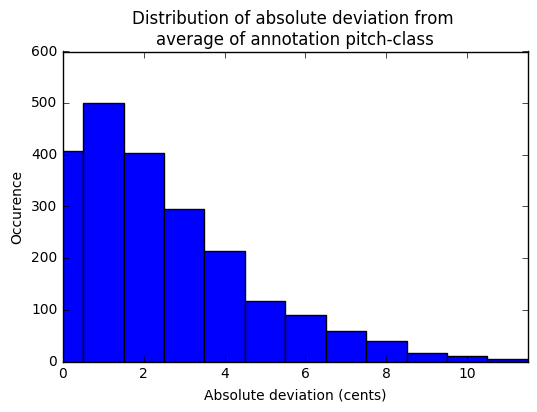

In [4]:
mean_dev = np.mean(tonic_dev)
std_dev = np.std(tonic_dev)

print("Total number of recordings: %d" %len(tonic_json))
print("Total number of annotations: %d" %sum(nums_anno))
print("The mean number of annotations per recording is %.1f with a standard deviation of %.1f"
      % (np.mean(nums_anno), np.std(nums_anno)))

print("Mean of absolute octave-wrapped deviation: %.1f cents" %mean_dev)
print("STD of absolute octave-wrapped deviation: %.1f cents" %std_dev)

dev_dist = PitchDistribution.from_cent_pitch(
    tonic_dev, step_size=1.0, kernel_width=0, norm_type=None)
dev_dist.bar()
plt.title('Distribution of absolute deviation from \naverage of annotation pitch-class')
plt.xlabel('Absolute deviation (cents)')
plt.xlim([min(dev_dist.bins), max(dev_dist.bins) + dev_dist.step_size/2])
plt.show()


Finally, we plot the histogram of tonic pitch classes and their transpositions. We take the step size for the histograms as 7.5 cents (~1/3 Hc), which was reported as an experimental optimal in (B. Bozkurt, 2008).

In addition, we check how many of the averaged annotations lie close to the intervals of the Eurogenetic 12 tone-equal-temperament (TET) system. We take a window of a single bin (7.5 cents) and three bins (22,5 cents; the bin itself and its left/right neighbors) in computation.

Reference 
----------
B. Bozkurt, 2008. "An automatic pitch analysis method for Turkish maqam music", Journal of New Music Research 37 1–13.

972 annotations out of 1990 lies close to 12-TET intervals within a window of 22.5 cents.
361 annotations out of 1990 lies close to 12-TET intervals within a window of 7.5 cents.


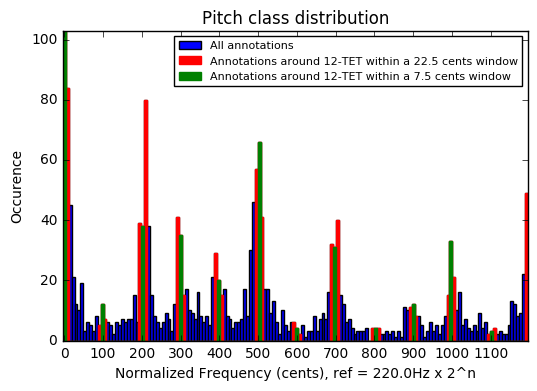

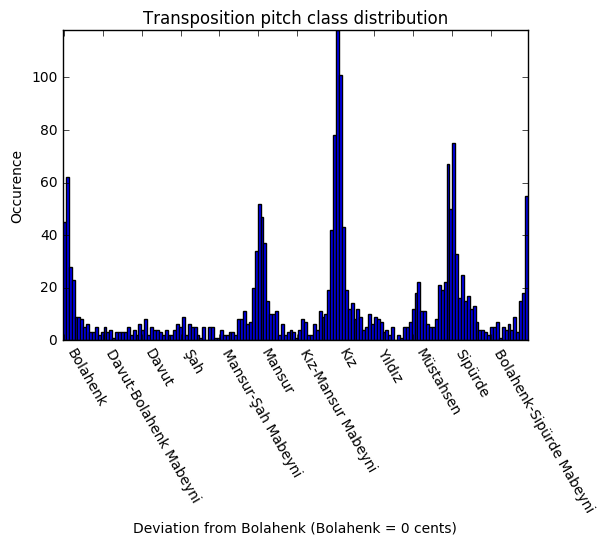

In [28]:
step_size = 7.5

# tonic pitch class distribution
tonic_dist = PitchDistribution.from_hz_pitch(
    tonic_array, step_size=step_size, kernel_width=0, ref_freq=220.0, norm_type=None)
tonic_dist.to_pcd()  # convert to pitch class distribution
tonic_dist.bar()
plt.axis('tight')
plt.title('Tonic pitch class distribution')
plt.xticks([100*i for i in xrange(12)])  # put an xtick for each semitone

# define a method to bar plot close bins in the given interval
def bar_close(tonic_dist, window_size, color):
    # find bins close to 12-TET intervals
    tonic12TET_dist = deepcopy(tonic_dist)

    tmp_bin = tonic12TET_dist.bins % 100

    is_bin_close = (tmp_bin <= window_size/2) | (tmp_bin >= 100 - window_size/2)
    tonic12TET_dist.vals[np.logical_not(is_bin_close)] = 0

    bars = tonic12TET_dist.bar()
    for bb in bars:
        bb.set_color(color)

    print("%d annotations out of %d lies close to 12-TET intervals within a window of %.1f cents."
          % (sum(tonic12TET_dist.vals), sum(tonic_dist.vals), window_size))
    
bar_close(tonic_dist, 3 * step_size, 'red')
bar_close(tonic_dist, step_size, 'green')

plt.legend(['All annotations', 'Annotations around 12-TET within a %.1f cents window' % (3 * step_size),
            'Annotations around 12-TET within a %.1f cents window' % step_size], prop={'size':8})
plt.show()

# transposition distribution
transposition_dist = PitchDistribution.from_cent_pitch(
    transposition_array, step_size=step_size, kernel_width=0, norm_type=None)
transposition_dist.bar()

ahenk_dict = ahenk_identifier._get_dict('ahenk')  # place xticks
name, cent = zip(*[(v['name'], v['cent_transposition']) for v in ahenk_dict.values()])
plt.xticks(cent, name, rotation='-60', ha='left')
plt.xlabel('Deviation from Bolahenk (Bolahenk = 0 cents)')
plt.title('Transposition pitch class distribution')
plt.axis('tight')
plt.show()


The spreads around the peaks observed in the tonic and transposition distributions show that the performed tonic frequencies do not neccessarily lie on the Euregenetic TET scale.

The transposition distribution shows that the most popular transpositions are _Kız, Sipürde, Bolahenk_ and _Mansur_. _Müstahsen_ is also performed relatively more than the rest of the transpositions.